In [ ]:
import qsharp

In [1]:
import sys
print(sys.executable)


C:\Users\marlo\anaconda3\python.exe


In [3]:
import qiskit

In [10]:
from qiskit import Aer

In [15]:
#!C:\Users\marlo\anaconda3\python.exe -m pip install qiskit[optimization]

  Using cached qiskit_optimization-0.5.0-py3-none-any.whl (156 kB)
  Using cached docplex-2.25.236-py3-none-any.whl


In [16]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [17]:

# Generating a graph of 3 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


NameError: name 'draw_graph' is not defined

order = (0, 1, 2) Distance = 202.0
Best order from brute force = (0, 1, 2) with total distance = 202.0


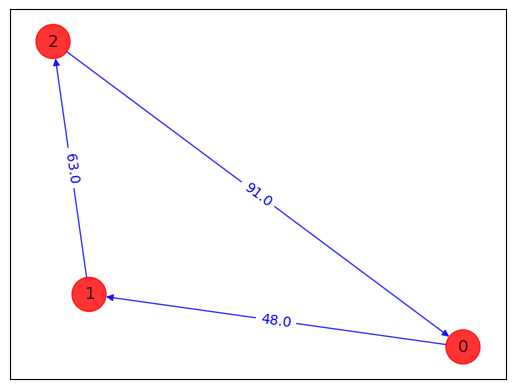

In [26]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

In [19]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())


Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [20]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
-1282.5 * IIIIIIIIZ
- 1282.5 * IIIIIIIZI
- 1282.5 * IIIIIIZII
- 1268.5 * IIIIIZIII
- 1268.5 * IIIIZIIII
- 1268.5 * IIIZIIIII
- 1290.0 * IIZIIIIII
- 1290.0 * IZIIIIIII
- 1290.0 * ZIIIIIIII
+ 606.5 * IIIIIIIZZ
+ 606.5 * IIIIIIZIZ
+ 606.5 * IIIIIIZZI
+ 606.5 * IIIIIZIIZ
+ 12.0 * IIIIIZIZI
+ 12.0 * IIIIIZZII
+ 12.0 * IIIIZIIIZ
+ 606.5 * IIIIZIIZI
+ 12.0 * IIIIZIZII
+ 606.5 * IIIIZZIII
+ 12.0 * IIIZIIIIZ
+ 12.0 * IIIZIIIZI
+ 606.5 * IIIZIIZII
+ 606.5 * IIIZIZIII
+ 606.5 * IIIZZIIII
+ 606.5 * IIZIIIIIZ
+ 22.75 * IIZIIIIZI
+ 22.75 * IIZIIIZII
+ 606.5 * IIZIIZIII
+ 15.75 * IIZIZIIII
+ 15.75 * IIZZIIIII
+ 22.75 * IZIIIIIIZ
+ 606.5 * IZIIIIIZI
+ 22.75 * IZIIIIZII
+ 15.75 * IZIIIZIII
+ 606.5 * IZIIZIIII
+ 15.75 * IZIZIIIII
+ 606.5 * IZZIIIIII
+ 22.75 * ZIIIIIIIZ
+ 22.75 * ZIIIIIIZI
+ 606.5 * ZIIIIIZII
+ 15.75 * ZIIIIZIII
+ 15.75 * ZIIIZIIII
+ 606.5 * ZIIZIIIII
+ 606.5 * ZIZIIIIII
+ 606.5 * ZZIIIIIII


In [27]:
result = exact.solve(qubo)
print(result.prettyprint())

NameError: name 'exact' is not defined

In [23]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

energy: -7379.0
tsp objective: 202.0
feasible: True
solution: [0, 1, 2]
solution objective: 202.0


NameError: name 'draw_tsp_solution' is not defined

In [24]:
%%qsharp
let indices = [1, size=9];
let expectation =  EstimateTermExpectation(, MeasurementOperators(nQubits, indices, termType : Int), coeffs : Double[], nQubits : Int, nSamples : Int) : Double


In [25]:
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

energy: -7326.024699521838
time: 21.37039875984192
feasible: True
solution: [1, 2, 0]
solution objective: 202.0


NameError: name 'draw_tsp_solution' is not defined